In [1]:
%reload_ext autoreload
%autoreload 2

import os
import warnings

import pandas as pd
import numpy as np

from hydra import compose, initialize, core
from omegaconf import OmegaConf

from src.short.ets import ETSTrainer
from src.short.arima import ArimaTrainer
from src.short.var import VARTrainer
from src.model_utils import CVHelper, S3Helper

## Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(
    version_base="1.2", config_path="../src/config", job_name="short_term_forecast"
)
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

## Configurations

The configurations for short-term (14 days or 2 weeks) forecasting:

In [3]:
config["short"]

{'output_key': 'data/processed/short',
 'start_date': '2023-01-01',
 'end_date': '2023-06-30',
 'forecast_horizon': 14,
 'freq': 'D',
 'm': 7,
 'window_length': 130,
 'step_length': 1,
 'metric': 'rmse',
 'date_features': ['quarter_of_year',
  'month_of_year',
  'week_of_year',
  'day_of_week'],
 'pred_interval': 0.9,
 'model_key': 'models/short',
 'forecasts_key': 'forecasts/short'}

## Train and Test Data

In [4]:
s3_helper = S3Helper()

y_train = s3_helper.read_parquet(
    obj_key=os.path.join(config["short"]["output_key"], "train.parquet")
)
y_test = s3_helper.read_parquet(
    obj_key=os.path.join(config["short"]["output_key"], "test.parquet")
)

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (167, 4)
y_test shape: (14, 4)


## ETS

The first model class we try is ETS (Error, Trend, Seasonality), which is non-stationary. Our modeling pipeline simply includes:

1. A log transformation
2. `AutoETS` 

We evaluate the model using time series cross-validation, tuning the `damped` hyperparameter (which dampens the trend of the forecasts). The window size and step size in the configurations above are set to ensure a certain number of fits:

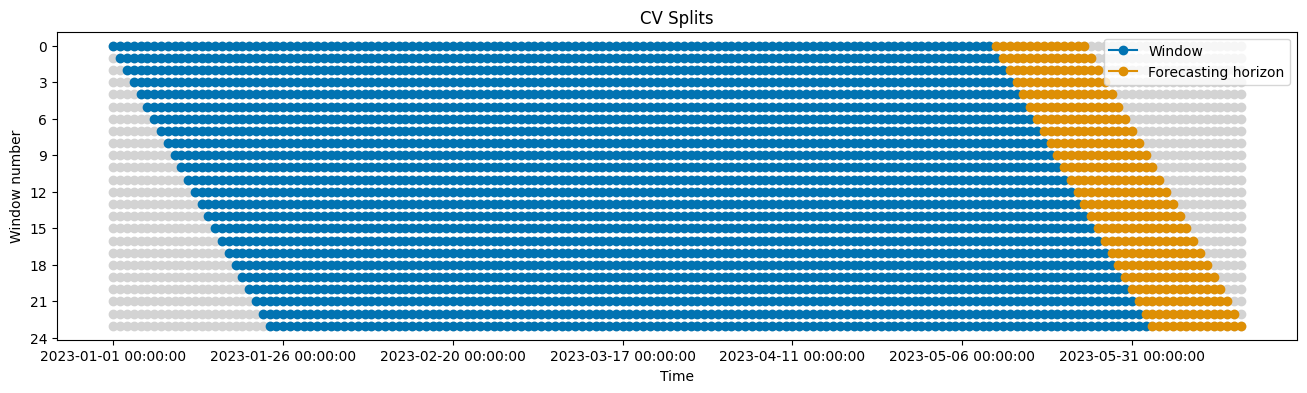

In [5]:
CVHelper.plot_cv_windows(
    w=config["short"]["window_length"],
    s=config["short"]["step_length"],
    h=config["short"]["forecast_horizon"],
    start_date=y_train["service_date"].min(),
    end_date=y_train["service_date"].max(),
    freq=config["short"]["freq"],
)

### Cross-Validation

In [6]:
ets_trainer = ETSTrainer(
    horizon="short",
    config_path="../src/config",
    config_name="ets_trainer",
    logger_name="ets_trainer",
    s3_helper=s3_helper,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ets_trainer.cross_validate(verbose=2, n_jobs=-1, refit=True)

2023-11-05 23:50:37,887 INFO ets_trainer: Ingesting data...
2023-11-05 23:50:38,016 INFO ets_trainer: Creating cross-validation splitter...
2023-11-05 23:50:38,017 INFO ets_trainer: Creating model...
Fitting 25 folds for each of 4 candidates, totalling 100 fits
2023-11-05 23:52:12,554 INFO ets_trainer: Best params: {'bus__ets__damped': True, 'rail_boardings__ets__damped': True}
2023-11-05 23:52:12,555 INFO ets_trainer: Best score: 39912.34146716712


Check CV results:

In [7]:
ets_trainer.grid_search.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,39912.341467,2.181248,0.042134,"{'bus__ets__damped': True, 'rail_boardings__et...",1.0
1,40094.399258,2.281414,0.080482,"{'bus__ets__damped': True, 'rail_boardings__et...",2.0
2,41444.505612,2.292379,0.079651,"{'bus__ets__damped': False, 'rail_boardings__e...",3.0
3,41626.563403,2.383569,0.061560,"{'bus__ets__damped': False, 'rail_boardings__e...",4.0


Best parameters:

In [8]:
pd.DataFrame(ets_trainer.grid_search.best_params_, index=["Best Params"])

,bus__ets__damped,rail_boardings__ets__damped
Best Params,True,True


### Diagnostics

In [9]:
diagnostics_cv_ets = ets_trainer.diagnostics(full_model=False)
diagnostics_cv_ets["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,9.064303e-11,True,True,True
1,Ljung-Box,No Autocorrelation,2.007816e-02,False,True,True


In [10]:
diagnostics_cv_ets["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,9.041042e-08,True,True,True
1,Ljung-Box,No Autocorrelation,1.790597e-03,True,True,True


### Forecasting Test Period

In [22]:
test_results_ets = ets_trainer.forecast(level=config["short"]["pred_interval"])

2023-11-06 16:10:53,786 INFO ets_trainer: Making predictions on test set...


2023-11-06 16:10:54,028 INFO ets_trainer: Test RMSE: 37019.60332512368


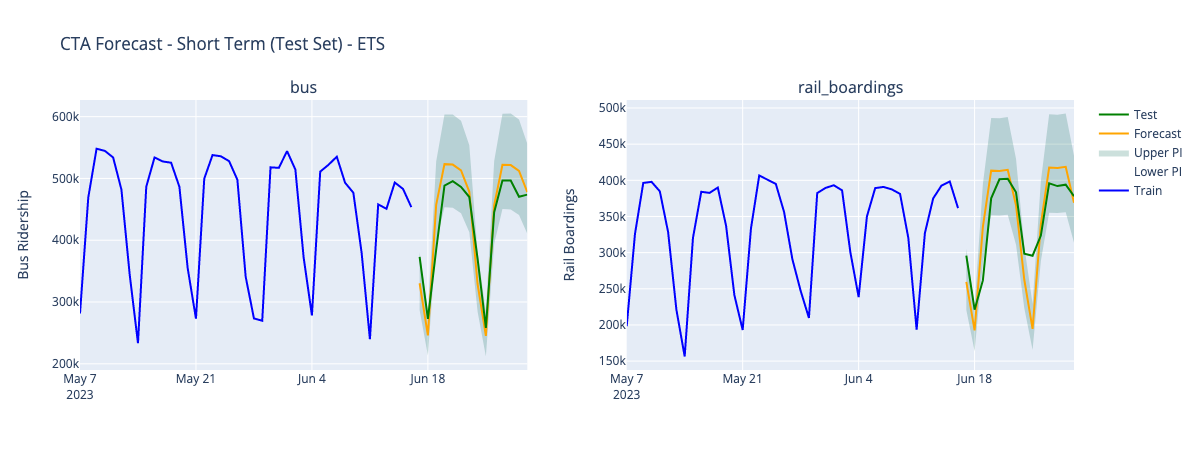

In [23]:
ets_trainer.plot_forecast(
    start_date=y_train["service_date"].max() - pd.Timedelta(days=40),
    pi=test_results_ets["pi"],
    y_train=test_results_ets["y_train"],
    y_pred=test_results_ets["y_pred"],
    y_test=test_results_ets["y_test"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Short Term (Test Set) - ETS",
)

### Retrain on Entire Data for Out-of-Sample Forecasting

Refit on entire data set:

In [20]:
forecast_results_ets = ets_trainer.refit_and_forecast(
    level=config["short"]["pred_interval"]
)

2023-11-06 16:10:12,117 INFO ets_trainer: Refitting model on entire data...


2023-11-06 16:10:41,087 INFO ets_trainer: Making out-of-sample forecasts...


Diagnostics on full model:

In [36]:
diagnostics_refit_ets = ets_trainer.diagnostics(full_model=True)
diagnostics_refit_ets["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,5.910076e-10,True,True,True
1,Ljung-Box,No Autocorrelation,4.090909e-02,False,True,True


In [37]:
diagnostics_refit_ets["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,7.723039e-10,True,True,True
1,Ljung-Box,No Autocorrelation,3.601212e-02,False,True,True


Controlling Type-I error rate at $5\%$, we reject both null hypotheses of normality and independence of errors.

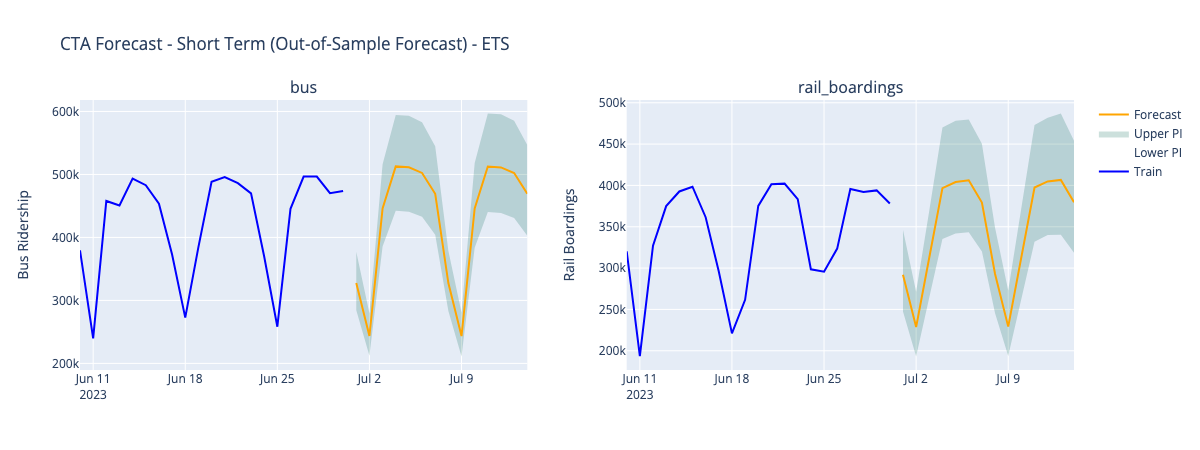

In [21]:
ets_trainer.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=20),
    pi=forecast_results_ets["pi"],
    y_train=forecast_results_ets["y_train"],
    y_pred=forecast_results_ets["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Short Term (Out-of-Sample Forecast) - ETS",
)

### Model Persistence

Upload trainer data to s3:

In [39]:
ets_trainer.upload_trainer(
    obj_key=os.path.join(config["short"]["model_key"], "ets_trainer.joblib")
)

2023-11-02 22:12:14,984 INFO ets_trainer: Uploaded trainer object to models/short/ets_trainer.joblib


## SARIMA

The next model class we explore is SARIMA(X), and the pipeline includes the following steps:

1. Log transform the target variables
2. Tunable step (on/off) to detrend the targets via a polynomial trend forecaster (i.e., regression model with polynomial features derived from the original series)
3. Tunable step (on/off) to deseasonalize the targets, which applies `statsmodels.tsa.seasonal.seasonal_compose` first and removes the `seasonal` component after the transform
4. Tunable step (on/off) to generate date features, which are used as exogenous (predictor) variables
5. Forecast using `AutoARIMA` to automatically select p, d, and q, and P, D, and Q, if needed

### Cross-Validation

In [ ]:
arima_trainer = ArimaTrainer(
    horizon="short",
    config_path="../src/config",
    config_name="arima_trainer",
    logger_name="arima_trainer",
    s3_helper=s3_helper,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    arima_trainer.cross_validate(verbose=2, n_jobs=-1, refit=True)

Cross-validation results:

In [31]:
arima_trainer.grid_search.cv_results_.sort_values(
    by="mean_test_MeanSquaredError", ascending=True
)

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
19,40579.538458,5.248012,0.092249,"{'bus__datetime__passthrough': True, 'bus__tar...",1.0
18,40588.116567,6.817598,0.085483,"{'bus__datetime__passthrough': True, 'bus__tar...",2.0
23,41092.188470,7.572067,0.108947,"{'bus__datetime__passthrough': True, 'bus__tar...",3.0
27,42342.937668,4.630552,0.102647,"{'bus__datetime__passthrough': True, 'bus__tar...",4.0
26,42351.515777,6.173308,0.093806,"{'bus__datetime__passthrough': True, 'bus__tar...",5.0
...,...,...,...,...,...
32,146214.821231,18.243938,0.129166,"{'bus__datetime__passthrough': False, 'bus__ta...",60.0
44,146477.429150,29.151179,0.209046,"{'bus__datetime__passthrough': False, 'bus__ta...",61.0
12,147200.252349,17.584720,0.113039,"{'bus__datetime__passthrough': True, 'bus__tar...",62.0
4,148167.632277,18.893535,0.231944,"{'bus__datetime__passthrough': True, 'bus__tar...",63.0


Best parameters:

In [18]:
pd.DataFrame(arima_trainer.grid_search.best_params_, index=["Best Params"])

,bus__datetime__passthrough,bus__target__deseasonalize__passthrough,bus__target__detrend__passthrough,rail_boardings__datetime__passthrough,rail_boardings__target__deseasonalize__passthrough,rail_boardings__target__detrend__passthrough
Best Params,True,False,True,True,False,False


For both target variables, the date exogenous features were not found to be useful in forecasting.

### Diagnostics

In [33]:
diagnostics_cv_sarimax = arima_trainer.diagnostics(full_model=False)
diagnostics_cv_sarimax["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,2.215886e-08,True,True,True
1,Ljung-Box,No Autocorrelation,5.732444e-03,True,True,True


In [34]:
diagnostics_cv_sarimax["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.400062e-09,True,True,True
1,Ljung-Box,No Autocorrelation,2.611187e-01,False,False,False


The model for `rail_boardings` appear to have independent errors as we fail to reject the null hypothesis at any Type-I error rate $\alpha$.

### Forecasting Test Period

In [16]:
test_results_sarimax = arima_trainer.forecast(level=config["short"]["pred_interval"])

2023-11-06 16:09:13,827 INFO arima_trainer: Making predictions on test set...


2023-11-06 16:09:14,085 INFO arima_trainer: Test RMSE: 39839.670744259594


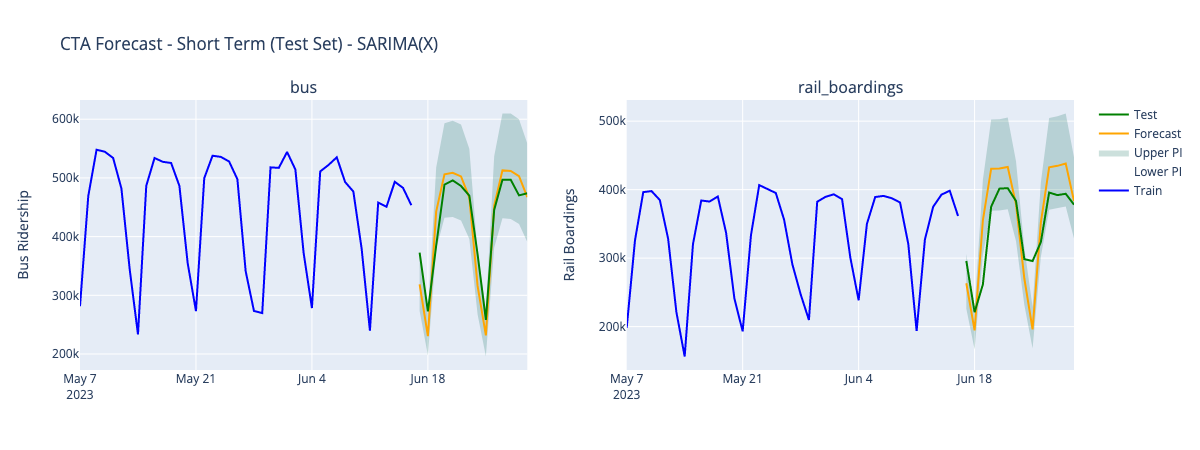

In [17]:
arima_trainer.plot_forecast(
    start_date=y_train["service_date"].max() - pd.Timedelta(days=40),
    pi=test_results_sarimax["pi"],
    y_train=test_results_sarimax["y_train"],
    y_pred=test_results_sarimax["y_pred"],
    y_test=test_results_sarimax["y_test"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Short Term (Test Set) - SARIMA(X)",
)

### Retrain on Entire Data for Out-of-Sample Forecasting

In [12]:
forecast_results_sarimax = arima_trainer.refit_and_forecast(
    level=config["short"]["pred_interval"]
)

2023-11-06 16:08:25,917 INFO arima_trainer: Refitting model on entire data...


2023-11-06 16:08:46,043 INFO arima_trainer: Making out-of-sample forecasts...


Diagnostics on full model:

In [38]:
diagnostics_refit_sarimax = arima_trainer.diagnostics(full_model=True)
diagnostics_refit_sarimax["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.689878e-08,True,True,True
1,Ljung-Box,No Autocorrelation,9.455004e-02,False,False,True


In [39]:
diagnostics_refit_sarimax["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.197142e-09,True,True,True
1,Ljung-Box,No Autocorrelation,1.703133e-01,False,False,False


While the residuals are not normal based on these tests, they are independent.

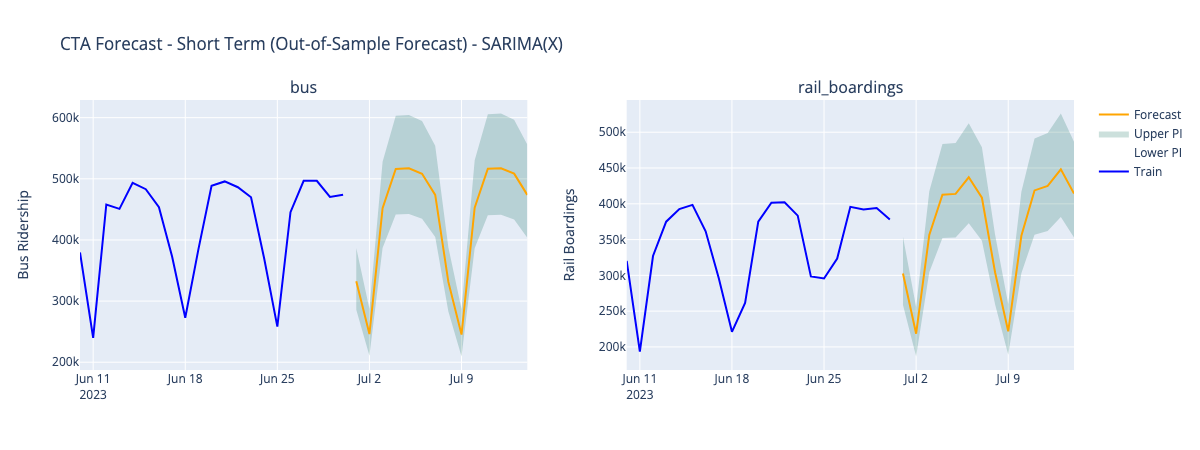

In [15]:
arima_trainer.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=20),
    pi=forecast_results_sarimax["pi"],
    y_train=forecast_results_sarimax["y_train"],
    y_pred=forecast_results_sarimax["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Short Term (Out-of-Sample Forecast) - SARIMA(X)",
)

### Model Persistence

In [41]:
arima_trainer.upload_trainer(
    obj_key=os.path.join(config["short"]["model_key"], "sarimax_trainer.joblib")
)

2023-11-02 23:30:44,956 INFO arima_trainer: Uploaded trainer object to models/short/sarimax_trainer.joblib


## Vector Auto-Regression

The final class of model we will use is vector regression models. For our data set of bus ridership and rail boardings, a bi-directional relationship may better represent the data. This feedback relationship is accounted for in the Vector Autoregressive (VAR) framework. A pth-order VAR model with $k$ variables can be expressed in general matrix notation:

$$
\underbrace{\begin{bmatrix}y_{1, t} \\ y_{2, t} \\ \vdots \\ y_{k, t}\end{bmatrix}}_{k \times 1} = 
\underbrace{\begin{bmatrix}c_1 \\ c_2 \\ \vdots \\ c_k\end{bmatrix}}_{k \times 1} + 
\begin{bmatrix}a_{1,1}^1 & a_{1,2}^1 & \cdots & a_{1, k}^1 \\ a_{2,1}^1 & a_{2,2}^1 & \cdots & a_{2, k}^1 \\ \vdots & \vdots & \ddots & \vdots \\ a_{k, 1}^1 & a_{k, 2}^1 & \cdots & a_{k, k}^1\end{bmatrix}
\begin{bmatrix}y_{1, t-1} \\ y_{2, t-1} \\ \vdots \\ y_{k, t-1}\end{bmatrix} + 
\cdots +
\begin{bmatrix}a_{1,1}^p & a_{1,2}^p & \cdots & a_{1, k}^p \\ a_{2,1}^p & a_{2,2}^p & \cdots & a_{2, k}^p \\ \vdots & \vdots & \ddots & \vdots \\ a_{k, 1}^p & a_{k, 2}^p & \cdots & a_{k, k}^p\end{bmatrix}
\begin{bmatrix}y_{1, t-p} \\ y_{2, t-p} \\ \vdots \\ y_{k, t-p}\end{bmatrix} + 
\begin{bmatrix}C_{1,1} & C_{1,2} & \cdots & C_{1,m} \\ C_{2,1} & C_{2,2} & \cdots & C_{2,m} \\ \vdots & \vdots & \ddots & \vdots \\ C_{k,1} & C_{k,2} & \cdots & C_{k,m} \end{bmatrix}
\begin{bmatrix} D_{1,t} \\ D_{2,t} \\ \vdots \\ D_{m,t} \end{bmatrix} + 
\underbrace{\begin{bmatrix}e_{1, t} \\ e_{2, t} \\ \vdots \\ e_{k, t}\end{bmatrix}}_{k \times 1}
$$

where

* $y_t$ is a $k$-vector

* $y_{t-i}$ is a $k$-vector of the ith lagged values of $y_t$

* $c$ is a $k$-vector of constants serving as the intercept of the model

* $A_i$ is a time-invariant (does not depend on $t$ ) $k \times k$ matrix of coefficients, where the element in the $i$-th row and $j$-th column of $A_p$ is denoted as $a_{i, j}^p$

* $C$ is a $k \times m$ matrix of coefficients for the deterministic regressors, where the element in the $i$-th row and $j$-th column of $C$ is denoted as $C_{i, j}$

* $D_{t}$ is an $m$-vector of deterministic regressors, where $m$ is the number of additional deterministic regressors (like constants, trends, seasonal dummies, exogenous variables, etc.) that have been included in the VAR model

* $e_t$ is a $k$-vector of error terms 

The error terms must satisfy three conditions:

1. $\mathrm{E}\left(e_t\right)=0$. Every error term has a mean of zero.
2. $\mathrm{E}\left(e_t e_t^{\prime}\right)=\Omega$. The contemporaneous covariance matrix of error terms is a $k \times k$ positive-semidefinite matrix denoted $\Omega$.
3. $\mathrm{E}\left(e_t e_{t-k}^{\prime}\right)=0$ for any non-zero $k$. There is no correlation across time. In particular, there is no serial correlation in individual error terms.

The above matrix notation can be re-written as:

$$
\begin{aligned}
y_{1, t} &= c_1 + [a_{1,1}^1 y_{1, t-1} + a_{1,2}^1 y_{2, t-1} + \cdots + a_{1, k}^1 y_{k, t-1}] + \cdots + [a_{1,1}^p y_{1, t-p} + a_{1,2}^p y_{2, t-p} + \cdots + a_{1, k}^p y_{k, t-p}] + [C_{1,1} D_{1,t} + C_{1,2} D_{2,t} + \cdots + C_{1,m} D_{m,t}] + e_{1, t} \\

y_{2, t} &= c_2 + [a_{2,1}^1 y_{1, t-1} + a_{2,2}^1 y_{2, t-1} + \cdots + a_{2, k}^1 y_{k, t-1}] + \cdots + [a_{2,1}^p y_{1, t-p} + a_{2,2}^p y_{2, t-p} + \cdots + a_{2, k}^p y_{k, t-p}] + [C_{2,1} D_{1,t} + C_{2,2} D_{2,t} + \cdots + C_{2,m} D_{m,t}] + e_{2, t} \\

&\vdots \\

y_{k, t} &= c_k + [a_{k, 1}^1 y_{1, t-1} + a_{k, 2}^1 y_{2, t-1} + \cdots + a_{k, k}^1 y_{k, t-1}] + \cdots + [a_{k, 1}^p y_{1, t-p} + a_{k, 2}^p y_{2, t-p} + \cdots + a_{k, k}^p y_{k, t-p}] + [C_{k,1} D_{1,t} + C_{k,2} D_{2,t} + \cdots + C_{k,m} D_{m,t}] + e_{k, t}
\end{aligned}
$$

Our modeling pipeline includes:

1. Log transform the targets
2. A tunable (on/off) step to apply a first a round of seasonal differencing, then a round of first (ordinary) differencing to remove seasonality and trend in the targets
3. Similar to the SARIMAX model, we experiment with detrending and deseasonalization
4. Generate date features to be used as exogenous variables
5. Forecast using VAR, tuning the trend parameter e.g., constant, constant + trend, constant, etc.
            
The order of the lags will be selected based on BIC for more parsimonious model, since AICc tends to overfit by choosing models with more parameters (fewer degrees of freedom).

### Cross-Validation

In [23]:
var_trainer = VARTrainer(
    horizon="short",
    config_path="../src/config",
    config_name="var_trainer",
    logger_name="var_trainer",
    s3_helper=s3_helper,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    var_trainer.cross_validate(verbose=2, n_jobs=-1, refit=True)

2023-11-02 22:08:15,434 INFO var_trainer: Ingesting data...
2023-11-02 22:08:16,237 INFO var_trainer: Creating cross-validation splitter...
2023-11-02 22:08:16,239 INFO var_trainer: Creating model...
Fitting 25 folds for each of 64 candidates, totalling 1600 fits
2023-11-02 22:09:38,416 INFO var_trainer: Best params: {'date_features__passthrough': True, 'target__deseasonalize__passthrough': False, 'target__detrend__passthrough': True, 'target__differencing__passthrough': True, 'target__var__trend': 'ctt'}
2023-11-02 22:09:38,418 INFO var_trainer: Best score: 40948.196163170665


CV results:

In [24]:
var_trainer.grid_search.cv_results_.sort_values(
    by="mean_test_MeanSquaredError", ascending=True
)

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
51,40948.196163,0.314826,0.046130,"{'date_features__passthrough': False, 'target_...",1.5
19,40948.196163,0.269696,0.049138,"{'date_features__passthrough': True, 'target__...",1.5
59,40948.196163,0.381736,0.060685,"{'date_features__passthrough': False, 'target_...",3.5
27,40948.196163,0.324415,0.061878,"{'date_features__passthrough': True, 'target__...",3.5
26,41821.295303,0.326373,0.058118,"{'date_features__passthrough': True, 'target__...",5.5
...,...,...,...,...,...
63,88880.232172,0.262658,0.052633,"{'date_features__passthrough': False, 'target_...",59.5
39,88880.232172,0.290970,0.056836,"{'date_features__passthrough': False, 'target_...",61.5
7,88880.232172,0.250913,0.053607,"{'date_features__passthrough': True, 'target__...",61.5
15,88880.232172,0.301746,0.068931,"{'date_features__passthrough': True, 'target__...",63.5


Best parameters:

In [19]:
pd.DataFrame(var_trainer.grid_search.best_params_, index=["Best Params"])

,date_features__passthrough,target__deseasonalize__passthrough,target__detrend__passthrough,target__differencing__passthrough,target__var__trend
Best Params,True,False,True,True,ctt


### Diagnostics

In [26]:
diagnostics_cv_var = var_trainer.diagnostics(full_model=False)
diagnostics_cv_var["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


In [27]:
diagnostics_cv_var["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


The var model trained on the entire training set has independent and normal residuals. Compared to the previous two model classes. This model performs worse in terms of our selected metric, RMSE; however, the model specifications appear to be very appropriate as the model assumptions are well satisfied.

### Forecasting Test Period

In [10]:
test_results_var = var_trainer.forecast(level=config["short"]["pred_interval"])

2023-11-06 16:08:15,855 INFO var_trainer: Making predictions on test set...
2023-11-06 16:08:16,031 INFO var_trainer: Test RMSE: 36924.21143735801


The VAR model actually achieved the best performance on the test set, indicating that the previous models overfitted to a larger degree.

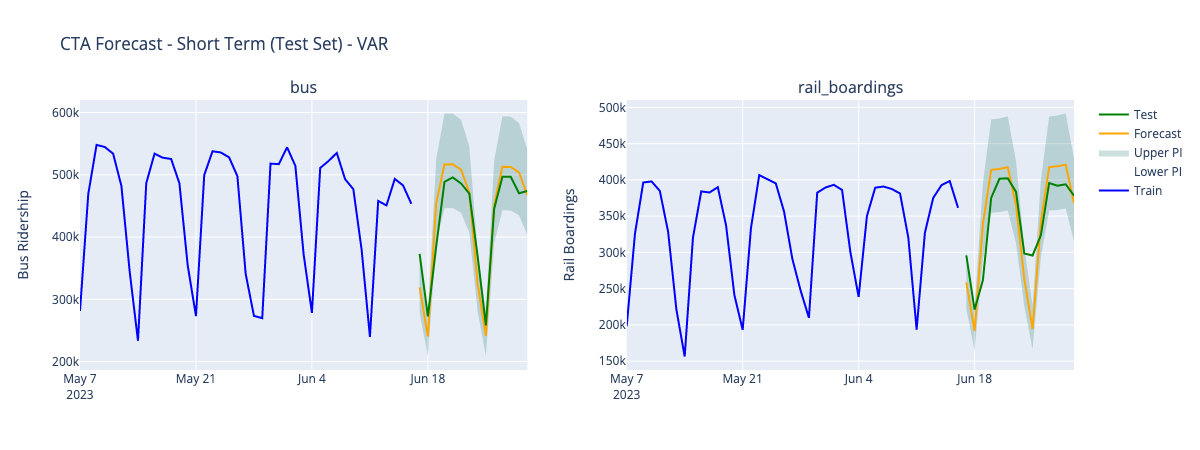

In [11]:
var_trainer.plot_forecast(
    start_date=y_train["service_date"].max() - pd.Timedelta(days=40),
    pi=test_results_var["pi"],
    y_train=test_results_var["y_train"],
    y_pred=test_results_var["y_pred"],
    y_test=test_results_var["y_test"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Short Term (Test Set) - VAR",
)

### Retrain on Entire Data for Out-of-Sample Forecasting

In [8]:
forecast_results_var = var_trainer.refit_and_forecast(
    level=config["short"]["pred_interval"]
)

2023-11-06 16:08:05,864 INFO var_trainer: Refitting model on entire data...


2023-11-06 16:08:06,068 INFO var_trainer: Making out-of-sample forecasts...


Diagnostics on full model:

In [43]:
diagnostics_refit_var = var_trainer.diagnostics(full_model=True)
diagnostics_refit_var["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


In [44]:
diagnostics_refit_var["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


Again, the model assumptions are well satisfied, indicating goodness of fit and appropriateness of the model class.

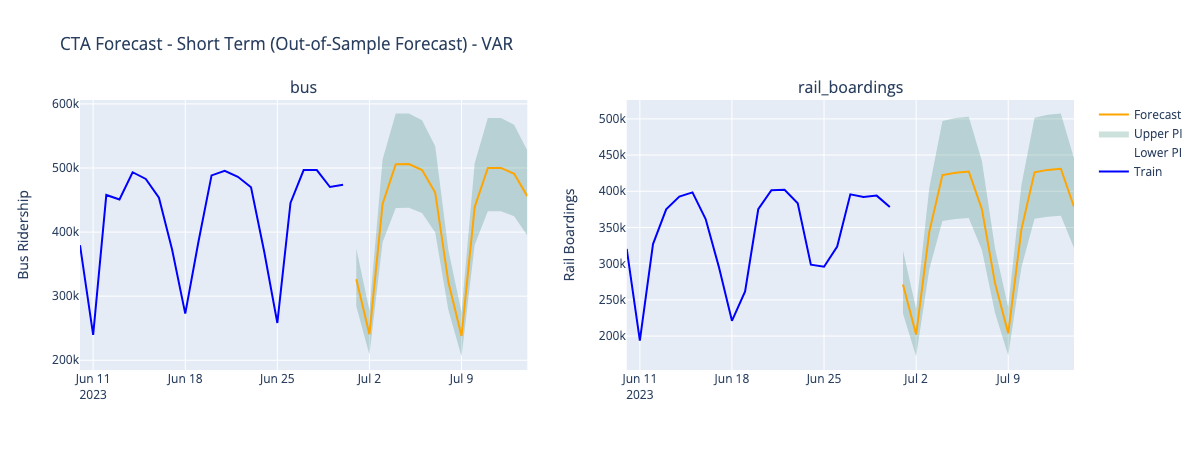

In [9]:
var_trainer.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=20),
    pi=forecast_results_var["pi"],
    y_train=forecast_results_var["y_train"],
    y_pred=forecast_results_var["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Short Term (Out-of-Sample Forecast) - VAR",
)

### Model Persistence

In [46]:
var_trainer.upload_trainer(
    obj_key=os.path.join(config["short"]["model_key"], "var_trainer.joblib")
)

2023-11-02 22:12:48,541 INFO var_trainer: Uploaded trainer object to models/short/var_trainer.joblib


## Model Weights

We apply a simple weighting scheme to combine the forecasts of the three models above:

$$
w_{i}=\frac{\frac{1}{\text{Test RMSE}}}{\text{Sum of Inverse Test RMSE of All Three Models}}
$$

First, load the trainers back into memory from S3:

In [6]:
model_s3_keys = [
    os.path.join(config["short"]["model_key"], f"{name}_trainer.joblib")
    for name in ["ets", "sarimax", "var"]
]

ets_trainer = ETSTrainer(
    horizon="short",
    config_path="../src/config",
    config_name="ets_trainer",
    logger_name="ets_trainer",
)
ets_trainer.download_trainer(obj_key=model_s3_keys[0])

arima_trainer = ArimaTrainer(
    horizon="short",
    config_path="../src/config",
    config_name="arima_trainer",
    logger_name="arima_trainer",
)
arima_trainer.download_trainer(obj_key=model_s3_keys[1])

var_trainer = VARTrainer(
    horizon="short",
    config_path="../src/config",
    config_name="var_trainer",
    logger_name="var_trainer",
)
var_trainer.download_trainer(obj_key=model_s3_keys[2])

2023-11-06 16:07:51,712 INFO ets_trainer: Downloaded trainer object from models/short/ets_trainer.joblib
2023-11-06 16:07:52,730 INFO arima_trainer: Downloaded trainer object from models/short/sarimax_trainer.joblib
2023-11-06 16:07:53,591 INFO var_trainer: Downloaded trainer object from models/short/var_trainer.joblib


Compure test RMSE and obtain out-of-sample forecasts. Note that we compute a single Test RMSE by taking the average between the Test RMSE's of each target variable--- 'bus' and 'rail'.

In [44]:
mses = {}
forecasts = {}
for trainer, trainer_name in zip(
    [ets_trainer, arima_trainer, var_trainer], ["ets", "sarimax", "var"]
):
    mses[trainer_name] = np.mean(
        np.sqrt(np.mean((trainer.y_pred - trainer.y_test) ** 2, axis=0))
    )
    forecasts[trainer_name] = trainer.y_forecast

mses

{'ets': 37019.60332512368,
 'sarimax': 39839.670744259594,
 'var': 36924.21143735801}

Compute weights:

In [45]:
inverse_mse_sum = sum([1 / mse for mse in mses.values()])

weights = {}
for trainer_name in mses:
    weights[trainer_name] = (1 / mses[trainer_name]) / inverse_mse_sum

weights

{'ets': 0.3410876144843276,
 'sarimax': 0.3169435879221442,
 'var': 0.34196879759352816}

Combine forecasts:

In [46]:
avg_forecasts = (
    weights["ets"] * forecasts["ets"]
    + weights["sarimax"] * forecasts["sarimax"]
    + weights["var"] * forecasts["var"]
)
avg_forecasts

,bus,rail_boardings
2023-07-01,328739.109592,288233.043486
2023-07-02,243357.984727,216357.703007
2023-07-03,447245.738188,337283.620625
2023-07-04,511491.640493,410591.781609
2023-07-05,511364.574161,414590.829922
2023-07-06,502382.244099,423152.064936
2023-07-07,468112.814418,387144.620487
2023-07-08,326816.630180,289649.314392
2023-07-09,242113.805427,218156.392891
2023-07-10,445683.714400,338186.659429


Save to S3:

In [48]:
s3_helper.to_parquet(
    data=avg_forecasts,
    obj_key=os.path.join(
        config["short"]["forecasts_key"], "short_term_avg_forecasts.parquet"
    ),
)